In [ ]:
import pandas as pd
import tensorflow as tf
import yaml
import os
import ast #for converting "[]" to []
from sklearn import model_selection
import numpy as np
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
import shutil #used for file copying
from tqdm import tqdm #Tqdm package is one of the more comprehensive packages for progress bars with python and is handy for those instances you want to build scripts that keep the users informed on the status of your application.

In [ ]:
!pip install -q kaggle

In [ ]:
!pip install --upgrade --force-reinstall --no-deps kaggle

In [ ]:
from google.colab import files
files.upload()

In [ ]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

mkdir: cannot create directory ‘/root/.kaggle’: File exists


#Download Data from Global-wheat-detection Kaggle comptetion

In [ ]:
!kaggle competitions download -c global-wheat-detection

#unzip all files

In [ ]:
!unzip global-wheat-detection.zip -d wheat_detection

#Clone into yolov5 

In [ ]:
!git clone  https://github.com/ultralytics/yolov5

In [ ]:
!pip install -U PyYAML

#Creat multible directories to save data 

In [ ]:
!mkdir wheat_data


In [ ]:
!mkdir /content/wheat_data/images


In [ ]:
!mkdir /content/wheat_data/labels


In [ ]:
!mkdir /content/wheat_data/images/train
!mkdir /content/wheat_data/images/validation


In [ ]:
!mkdir /content/wheat_data/labels/train
!mkdir /content/wheat_data/labels/validation

In [ ]:
input_path = '/content/wheat_detection'
output_path = '/content/wheat_data'

def process_data(data, data_type = "train"):
    for _, row in tqdm (data.iterrows(), total = len(data)):
        image_name = row["image_id"]
        bounding_boxes = row["bboxes"]
        yolo_data = []
        for bbox in bounding_boxes:
            x = bbox[0]
            y = bbox[1]
            w = bbox[2]
            h = bbox[3]
            x_center = x + w /2
            y_center = y + h /2
            x_center /= 1024.0
            y_center /= 1024.0
            w /= 1024.0
            h /= 1024.0
            yolo_data.append([0, x_center, y_center, w, h]) #first we append the class to which bounding box belongs to
        yolo_data = np.array(yolo_data)
        np.savetxt(
            os.path.join(output_path, f"labels/{data_type}/{image_name}.txt"), 
            yolo_data,
            fmt = ["%d", "%f", "%f", "%f", "%f"]
        )
        shutil.copyfile(
            os.path.join(input_path, f"train/{image_name}.jpg"),
            os.path.join(output_path, f"images/{data_type}/{image_name}.jpg")
        )

if __name__ == "__main__":
  df = pd.read_csv(os.path.join(input_path, 'train.csv' ))
  df.bbox = df.bbox.apply(ast.literal_eval)
  df = df.groupby('image_id')['bbox'].apply(list).reset_index(name = 'bboxes')
  
  df_train,df_validate = model_selection.train_test_split(df,test_size = 0.1, random_state=42, shuffle = True)

  df_train = df_train.reset_index(drop=True)
  df_validate = df_validate.reset_index(drop=True)

  process_data(df_train, data_type='train')
  process_data(df_validate, data_type='validation')

100%|██████████| 338/338 [00:00<00:00, 887.83it/s]


In [ ]:
df_train.head(10)


,image_id,bboxes
0,6d34eb3b2,"[[391, 760, 87, 80], [208, 400, 149, 79], [215..."
1,c7c00c1a3,"[[91, 10, 91, 66], [753, 0, 58, 38], [570, 0, ..."
2,09b4141a6,"[[245.0, 240.0, 113.0, 110.0], [296.0, 709.0, ..."
3,e837f4e67,"[[491.0, 473.0, 159.0, 87.0], [558.0, 225.0, 8..."
4,f1d20d58a,"[[459.0, 917.0, 153.0, 103.0], [684.0, 5.0, 60..."
5,894baab2e,"[[0, 124, 31, 87], [105, 102, 57, 61], [186, 1..."
6,a28dcf45d,"[[0, 403, 26, 94], [150, 154, 125, 68], [378, ..."
7,7ff95f9ec,"[[614, 239, 143, 139], [905, 90, 111, 130], [8..."
8,8dd8f0ca6,"[[50.0, 80.0, 56.0, 93.0], [73.0, 289.0, 64.0,..."
9,e935b9eea,"[[6.0, 0.0, 75.0, 86.0], [27.0, 109.0, 63.0, 8..."


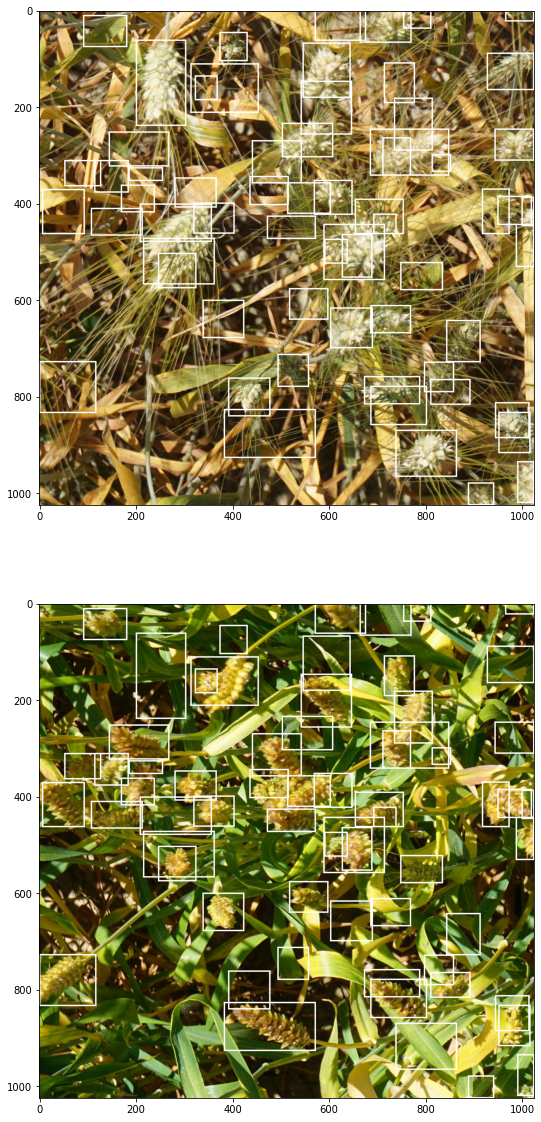

In [ ]:
def display_images(sample):
  f, ax = plt.subplots(len(sample), figsize = (20,20))
  for i, image_id in enumerate(sample['image_id']):
    image_path = os.path.join('/content/wheat_detection/train', f'{image_id}.jpg')
    image = Image.open(image_path)
    draw = ImageDraw.Draw(image)
    for bbox1 in sample['bboxes']:
      for bbox2 in bbox1:
        draw.rectangle([bbox2[0], bbox2[1], bbox2[0] + bbox2[2], bbox2[1] + bbox2[3]], width = 3)
    ax[i].imshow(image)

display_images(df_train.head(2))

#create Yaml file for training model with it 

In [ ]:
import yaml

wheat= dict(
train= '/content/wheat_data/images/train',
val= '/content/wheat_data/images/validation',
nc= 1,
names= ["wheat"]

)

with open('wheat.yaml', 'w') as outfile:
    yaml.dump(wheat, outfile, default_flow_style=False)

In [ ]:
!cat wheat.yaml


names:
- wheat
nc: 1
train: /content/wheat_data/images/train
val: /content/wheat_data/images/validation


In [ ]:
!ls /content/yolov5/models

common.py	 export.py  __init__.py  yolov5l.yaml  yolov5s.yaml
experimental.py  hub	    yolo.py	 yolov5m.yaml  yolov5x.yaml


In [ ]:
%load_ext tensorboard

#Training model 

In [ ]:
!python3 /content/yolov5/train.py --img 1024 --batch 8 --epochs 15 --data /content/wheat.yaml --cfg /content/yolov5/models/yolov5s.yaml --name wheat_detector_model

In [ ]:
tensorboard --logdir runs

#predict the test images

In [ ]:
!python3 /content/yolov5/detect.py --source /content/wheat_detection/test --weights /content/runs/train/wheat_detector_model/weights/best.pt


#show prediction on one of the test images

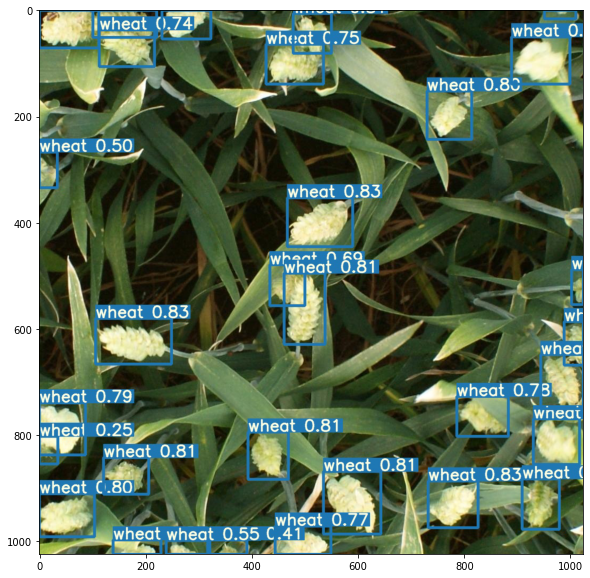

In [ ]:
fig, ax = plt.subplots(figsize = (10, 10))
image = Image.open('runs/detect/exp/2fd875eaa.jpg')
ax.imshow(image)

#Save best weights to drive 

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
%cp /content/runs/train/wheat_detector_model/weights/best.pt/content/gdrive/My\ Drive